In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

# with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_sample_eddies.pkl', 'rb') as f:
#     dic_sample = pickle.load(f)
with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, rossby_number


In [2]:
sample_eddies = [474, 971, 1917, 1978, 33, 207, 1783, 2370]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]


In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [106]:
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


Text(0, 0.5, 'Latitude (°N)')

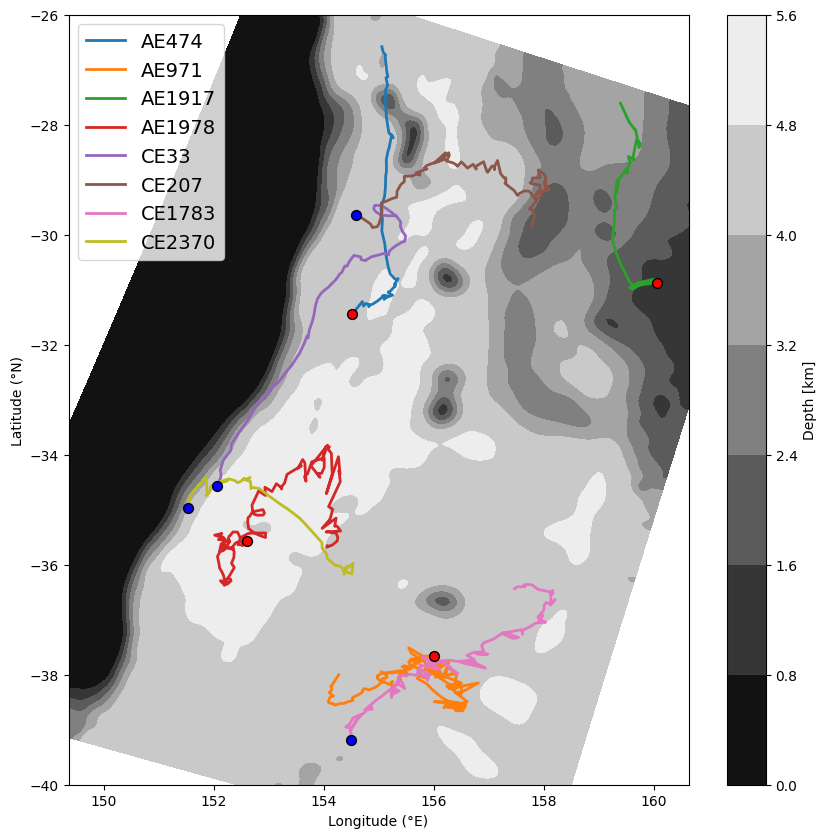

In [38]:
plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, h/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

for e, eddy in enumerate(sample_eddies):

    df = df_eddies[df_eddies.Eddy==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['Lon'], df['Lat'], label=f'{cyc}{eddy}',
            linewidth=2, color=colors[e%len(colors)])
    plt.scatter(df.iloc[-1]['Lon'], df.iloc[-1]['Lat'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)

plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
plt.xlim(150, 160)
plt.ylim(-40, -26)
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')


#### Side Profiles

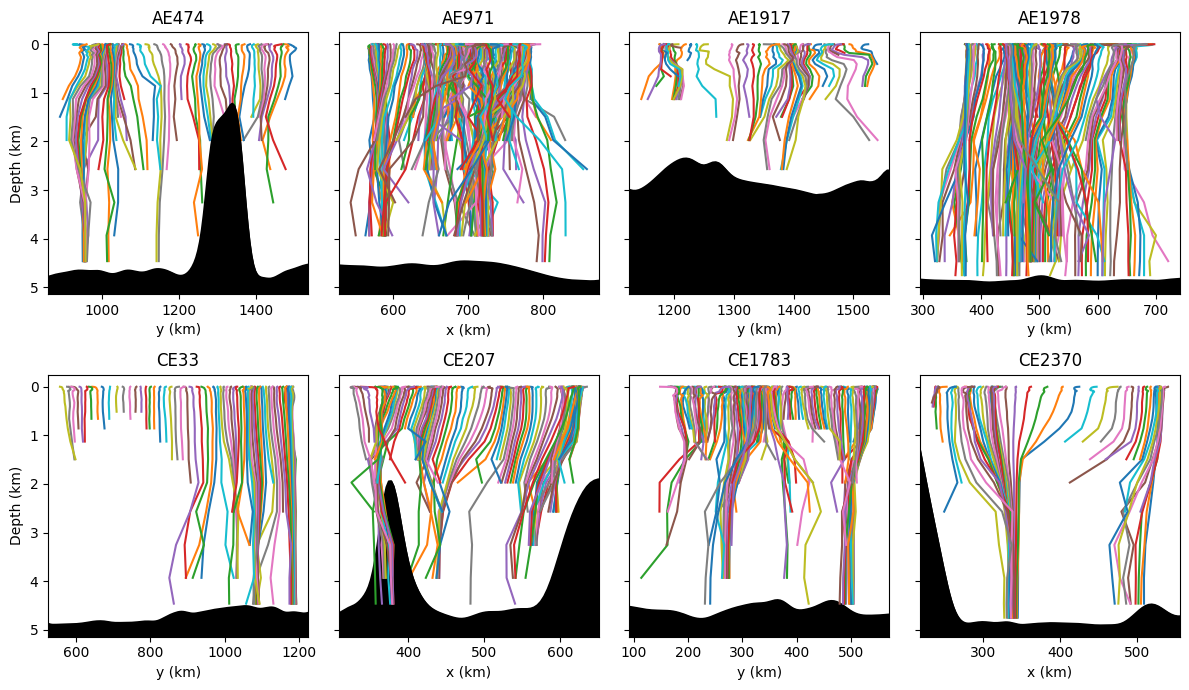

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(12,7), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    if eddy in [971, 207, 2370]:
        flagx = True
    else:
        flagx = False
    days = dic_eddies_vert[f'Eddy{eddy}']
    df_all = pd.concat(
        [df0 for df0 in days.values() if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )
    df_mean = pd.DataFrame([{
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }])
    
    dic = dic_eddies_vert[f'Eddy{eddy}']
    pmean = df_mean[df_mean.Eddy==eddy].iloc[0]
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            if flagx:
                ax.plot(df.x, -df.Depth/1000, zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
                ax.set_xlabel('x (km)')
            else:
                ax.plot(df.y, -df.Depth/1000, zorder=2 if df.iloc[-1].x > pmean.x_mean else 0)
                ax.set_xlabel('y (km)')
    xlim = ax.get_xlim()

    if flagx:
        jc = np.where(np.abs(pmean.y_mean-y_grid)==np.min(np.abs(pmean.y_mean-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k', zorder=1)
    else:
        ic = np.where(np.abs(pmean.x_mean-x_grid)==np.min(np.abs(pmean.x_mean-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k', zorder=1)
    
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
axs[0,0].set_ylabel('Depth (km)')
axs[1,0].set_ylabel('Depth (km)')
axs[0,0].invert_yaxis()
plt.tight_layout()


#### Depths

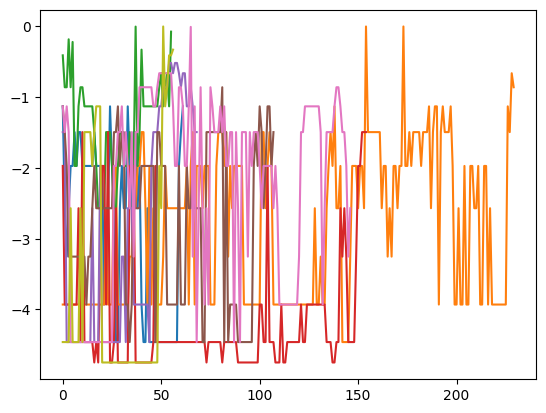

In [40]:
for e, eddy in enumerate(dic_sample.keys()):
    dic = dic_sample[eddy]
    depths = []
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            depths.append(-df.iloc[-1]['Depth']/1000)
        else:
            depths.append(0)
    plt.plot(-np.array(depths), color=colors[e])


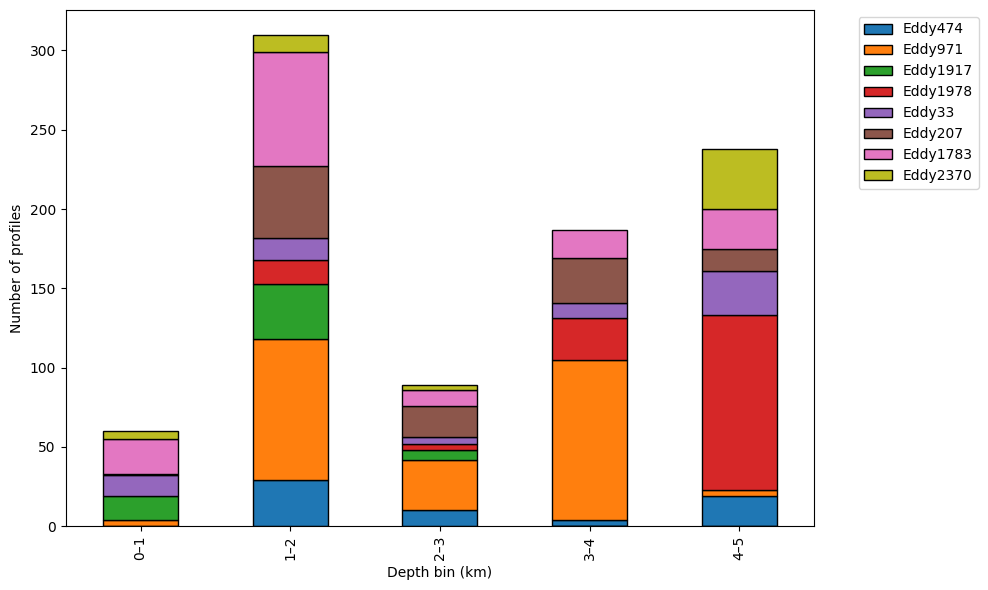

In [43]:
# Adjustable bin width
bin_width = 1  # km
max_depth_km = 5  # adjust as needed

# Create bin edges and labels
bins = np.arange(0, max_depth_km + bin_width, bin_width)
bin_labels = [f"{round(b,1)}–{round(b+bin_width,1)}" for b in bins[:-1]]

# Prepare DataFrame
eddy_names = list(dic_sample.keys())
bin_counts = pd.DataFrame(0, index=bin_labels, columns=eddy_names)

# Fill in counts
for e, eddy in enumerate(eddy_names):
    dic = dic_sample[eddy]
    depths = []
    for day in dic:
        df = dic[day].copy()
        if len(df):
            depth_km = -df.iloc[-1]['Depth'] / 1000
            depths.append(depth_km)
        else:
            depths.append(0)

    counts, _ = np.histogram(depths, bins=bins)
    bin_counts.loc[:, eddy] = counts

# Plot
bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='black', color=colors)
plt.xlabel('Depth bin (km)')
plt.ylabel('Number of profiles')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

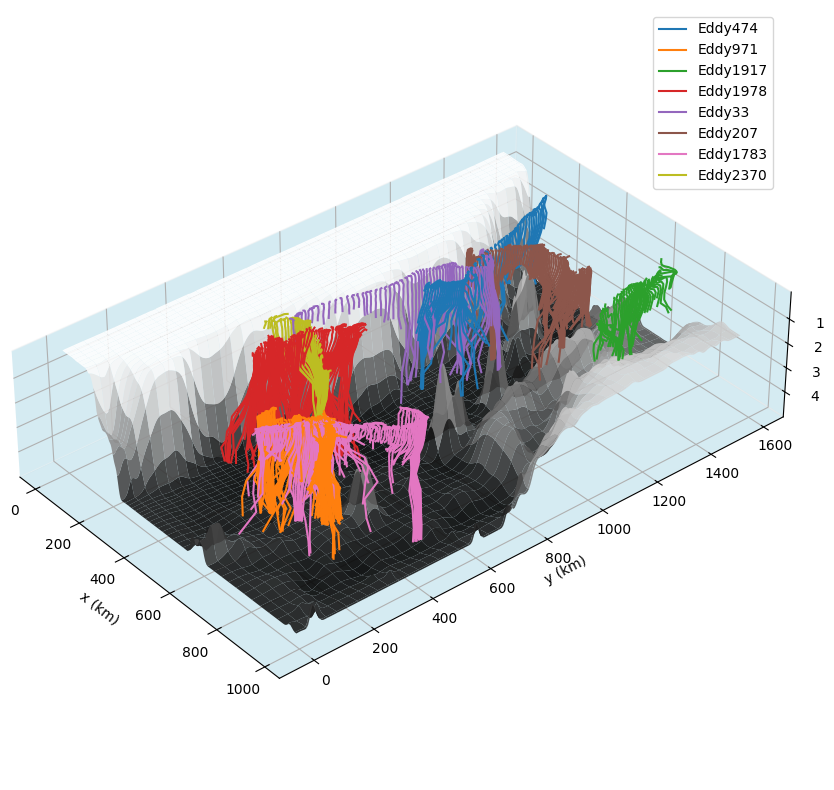

In [56]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.pane.set_facecolor("lightblue")
ax.yaxis.pane.set_facecolor("lightblue")
ax.zaxis.pane.set_facecolor("lightblue")

ax.plot_surface(
    X_grid, Y_grid, h/1000,
    cmap="Greys", edgecolor="none",
    alpha=0.9, zorder=0
)

for e, (eddy, dic) in enumerate(dic_sample.items()):
    for d, (day, df) in enumerate(dic.items()):
        if len(df):
            if d == 0: 
                ax.plot(df.x, df.y, -df.Depth/1000, zorder=Y_grid.max()-round(df.iloc[0].y),
                        color=colors[e % 9], label=eddy)
            else:
                ax.plot(df.x, df.y, -df.Depth/1000, zorder=Y_grid.max()-round(df.iloc[0].y), color=colors[e % 9])

ax.invert_zaxis()

# --- equal aspect without wasting space ---
xlims = ax.get_xlim()
ylims = ax.get_ylim()
zlims = ax.get_zlim()

dx = xlims[1] - xlims[0]
dy = ylims[1] - ylims[0]
dz = zlims[1] - zlims[0]

ax.set_box_aspect([dx, dy, 400])  # scale by actual data ranges

# view angle
ax.view_init(elev=35, azim=-40)

ax.set_xlabel("x (km)")
ax.set_ylabel("y (km)")
ax.set_zlabel("Depth (km)")
ax.legend()
plt.show()


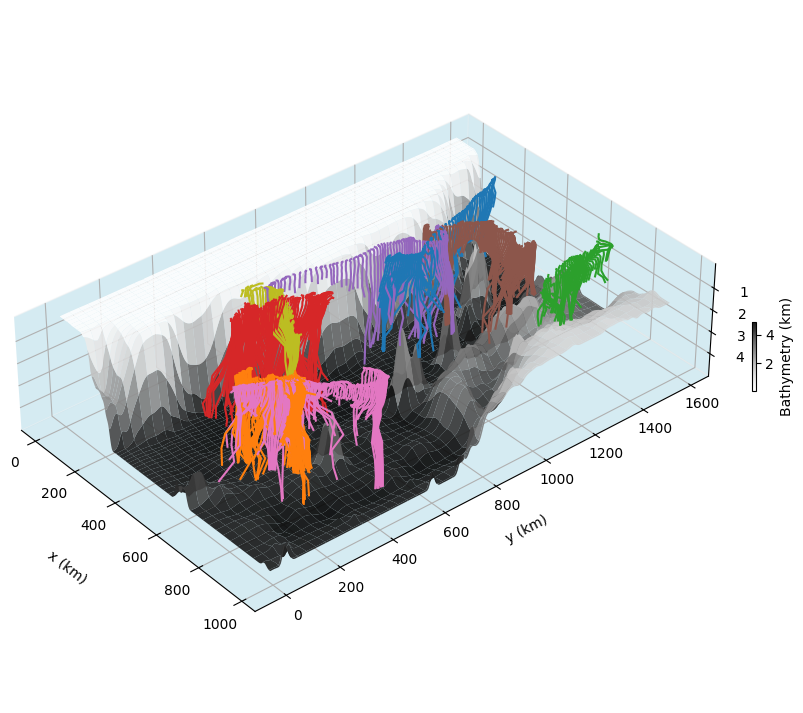

In [111]:
# def load_plot_payload(path):
#     with gzip.open(path, 'rb') as f: 
#         return pickle.load(f)

# path = '/srv/scratch/z5297792/' # CHANGE TO PATH

# # give the file to your collaborator, they do:
# data = load_plot_payload(path+'plot_payload.pkl.gz')
# X_grid = data['X_grid']; Y_grid = data['Y_grid']; h = data['h']
# dic_sample = data['dic_sample']; colors = data['colors']

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.pane.set_facecolor("lightblue")
ax.yaxis.pane.set_facecolor("lightblue")
ax.zaxis.pane.set_facecolor("lightblue")

# --- plot bathymetry and keep reference ---
surf = ax.plot_surface(
    X_grid, Y_grid, h/1000,
    cmap="Greys", edgecolor="none",
    alpha=0.9, zorder=0
)

for e, (eddy, dic) in enumerate(dic_sample.items()):
    for d, (day, df) in enumerate(dic.items()):
        if len(df):
            if d == 0: 
                ax.plot(df.x, df.y, -df.Depth/1000,
                        zorder=Y_grid.max()-round(df.iloc[0].y),
                        color=colors[e % 9], label=eddy)
            else:
                ax.plot(df.x, df.y, -df.Depth/1000,
                        zorder=Y_grid.max()-round(df.iloc[0].y),
                        color=colors[e % 9])

ax.invert_zaxis()

# --- equal aspect without wasting space ---
xlims = ax.get_xlim()
ylims = ax.get_ylim()
zlims = ax.get_zlim()
dx, dy, dz = xlims[1]-xlims[0], ylims[1]-ylims[0], zlims[1]-zlims[0]
ax.set_box_aspect([dx, dy, 400])

# view angle
ax.view_init(elev=35, azim=-40)

ax.set_xlabel("x (km)", labelpad=15)
ax.set_ylabel("y (km)", labelpad=15)
ax.set_zlabel("Depth (km)", labelpad=20)
# ax.legend(loc='lower right', ncol=4)

cbar = fig.colorbar(surf, ax=ax, orientation="vertical", shrink=0.1, pad=0.05)
cbar.set_label("Bathymetry (km)")

plt.show()


In [108]:


# import gzip, pickle, numpy as np, pandas as pd

# def export_plot_payload(path, X_grid, Y_grid, h, dic_sample, colors=None):
#     slim = {}
#     for eddy, days in dic_sample.items():
#         slim[eddy] = {}
#         for day, df in days.items():
#             if df is None or len(df)==0: 
#                 continue
#             slim[eddy][day] = df[['x','y','Depth']].reset_index(drop=True)
#     payload = {
#         'X_grid': np.asarray(X_grid),
#         'Y_grid': np.asarray(Y_grid),
#         'h':      np.asarray(h),
#         'dic_sample': slim,
#         'colors': colors
#     }
#     with gzip.open(path, 'wb') as f: pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)





# # save
# export_plot_payload(path + 'plot_payload.pkl.gz', X_grid, Y_grid, h, dic_sample, colors=colors)







In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

#### Ellipticity

##### Depth

In [ ]:
df_means = pd.DataFrame([
    {
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }
    for eddy, days in dic_sample.items()
    for df_all in [pd.concat(
        [df0 for df0 in days.values() 
         if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )]
])


In [ ]:
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        df = dic[day]

        if len(df):

            Qs = df['Q'].values.copy()
            Rcs = df['Rc'].values.copy()
            psi0s = df['psi0'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km
            
            # smooth against frame index t
            window = 50
            sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=window)
            sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=window)
            sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=window)
    
            df['sw'] = 2 * (sq11 + sq22)
            df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
            
            df['sRc']   = smooth(Rcs,                    depths, window=window)
            df['spsi0'] = smooth(psi0s,                  depths, window=window)
            


In [ ]:
days_me = [np.array([ 0,  5, 10, 17, 24, 28, 31, 41, 58]),
 np.array([  5,  30, 47,  76,  127, 135]),
 np.array([ 0,  6, 12, 31, 38, 53]),
 np.array([30,  51,  68, 103, 137]),
 
 np.array([ 2, 16, 30, 38, 44, 49, 55, 59, 62, 68]),
 np.array([  0,    36,  45,  55,  63,  79,  89, 107]),
 np.array([  10,  33,  44,  50, 66, 114, 130, 145]),
 np.array([ 0,  16, 19, 21, 25, 40, 49, 56])]

days_p = []
for e, (eddy, dic) in enumerate(dic_sample.items()):
   
    days = np.array(list(dic.keys()))[days_me[e]]
    days_p.append(days)


In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(10,12), sharey=True)

colors = plt.get_cmap('tab10').colors
for e, eddy in enumerate(sample_eddies):
    ax = axs[e % 4, e // 4]
    if eddy in [971, 207, 2370]:
        flagx = True
    else:
        flagx = False
    days = dic_eddies_vert[f'Eddy{eddy}']
    df_all = pd.concat(
        [df0 for df0 in days.values() if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )
    df_mean = pd.DataFrame([{
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }])
    
    dic = dic_eddies_vert[f'Eddy{eddy}']
    pmean = df_mean[df_mean.Eddy==eddy].iloc[0]
    day_idx = 0
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            if flagx:
                ax.plot(df.x, -df.Depth/1000, linewidth=.5, color='k', alpha=.2,
                            zorder=-1)
                ax.set_xlabel('x (km)')
            else:
                ax.plot(df.y, -df.Depth/1000, linewidth=.5, color='k', alpha=.2,
                            zorder=-1)

            if day in days_p[e]:

                if flagx:
                    ax.plot(df.x, -df.Depth/1000, color=colors[day_idx % 10],
                            zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
                else:
                    ax.plot(df.y, -df.Depth/1000, color=colors[day_idx % 10],
                            zorder=2 if df.iloc[-1].x > pmean.x_mean else 0)

                # raw data
                xs = df['x'].values.copy()
                ys = df['y'].values.copy()
                sQs = df['sQ'].values.copy()
                sq11 = [q[0,0] for q in sQs]
                sq12 = [q[0,1] for q in sQs]
                sq22 = [q[1,1] for q in sQs]
                sRc = df['sRc'].values.copy()
                spsi0 = df['spsi0'].values.copy()
                depths = -df['Depth'].values.copy() / 1000  # in km


                for x0, y0, q11, q12, q22, Rc, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, depths):
                    Qm = np.array([[q11, q12],[q12, q22]])
                    xe, ye = plot_ellipse(Qm, (x0, y0), scale=Rc/5)
                    ze = np.full_like(xe, z0)
                    if flagx:
                        ax.plot(xe, ze, color=colors[day_idx % 10], alpha=0.8,
                                zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
                        ax.text(xs[0], -.05, d, color=colors[day_idx % 10], fontweight='bold')
                    else:
                        ax.plot(ye, ze, color=colors[day_idx % 10], alpha=0.8,
                                zorder=2 if df.iloc[-1].x > pmean.x_mean else 0)
                        ax.text(ys[0], -.05, d, color=colors[day_idx % 10], fontweight='bold')
                day_idx += 1
    
    ax.set_xlabel('y (km)')
    xlim = ax.get_xlim()

    if flagx:
        jc = np.where(np.abs(pmean.y_mean-y_grid)==np.min(np.abs(pmean.y_mean-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k', zorder=1)
    else:
        ic = np.where(np.abs(pmean.x_mean-x_grid)==np.min(np.abs(pmean.x_mean-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k', zorder=1)
    
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if e < 4:
        ax.set_ylabel('Depth (km)')
        
axs[0,0].invert_yaxis()
axs[0,0].set_ylim(None, -.5)
plt.tight_layout()


##### Surface

In [ ]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

flip_xy_ids = {971, 207, 2370}
eds = list(dic_sample.keys())
nrows, ncols = 2, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(13, 8))
axs = axs.ravel()

# global day range for consistent colours across panels
max_days = max(len(v) for v in dic_sample.values())
norm = Normalize(vmin=0, vmax=max_days - 1)
cmap = cool
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

for e, eddy in enumerate(eds[: nrows * ncols]):
    ax = axs[e]
    eddy_id = int(eddy[4:]) if isinstance(eddy, str) else int(eddy)
    flagx = eddy_id in flip_xy_ids

    xs, ys, Qs, Rcs, ds = [], [], [], [], []
    for d, day in enumerate(sorted(dic_sample[eddy].keys())):
        df = dic_sample[eddy][day]
        if df.empty:
            continue

        xs.append(df.iloc[0]['x'])
        ys.append(df.iloc[0]['y'])

        sQ = df.iloc[0]['sQ']
        Qs.append(np.array(sQ) if not np.any(np.isnan(sQ)) else df.iloc[0]['Q'])

        Rc = df.iloc[0]['Rc']
        Rcs.append(Rc if not np.isnan(Rc) else df.iloc[0]['sRc'])

        ds.append(d)

    if not ds:
        ax.set_title(str(eddy))
        continue

    days = np.array(ds)
    window = 5
    sq11 = smooth([q[0, 0] for q in Qs], days, num=len(days), window=window)
    sq12 = smooth([q[0, 1] for q in Qs], days, num=len(days), window=window)
    sq22 = smooth([q[1, 1] for q in Qs], days, num=len(days), window=window)
    sRc = smooth(Rcs, days, num=len(days), window=window)

    if flagx:
        ax.plot(xs, ys, lw=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('x (km)'); ax.set_ylabel('y (km)')
    else:
        ax.plot(ys, xs, lw=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('y (km)'); ax.set_ylabel('x (km)')

    for xi, yi, a, b, c, scale, day in zip(xs, ys, sq11, sq12, sq22, sRc, days):
        Qm = np.array([[a, b], [b, c]])
        xe, ye = plot_ellipse(Qm, (xi, yi), scale=scale)
        if flagx:
            ax.plot(xe, ye, color=cmap(norm(day)), alpha=.8)
        else:
            ax.plot(ye, xe, color=cmap(norm(day)), alpha=.8)

    cyc = df_eddies.loc[df_eddies.Eddy == eddy_id, 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy_id}')
    ax.set_aspect('equal', 'box')

# one shared colourbar for all subplots
cbar = fig.colorbar(sm, ax=axs.tolist(), orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Day')
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()


In [ ]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 4, figsize=(13, 8))

for e, eddy in enumerate(dic_sample):
    if int(eddy[4:]) in [971, 207, 2370]:
        flagx = True
    else:
        flagx = False
    ax = axs[e // 4, e % 4]
    xs, ys, Qs, Rcs, Ros, ds = [], [], [], [], [], []
    for d, day in enumerate(dic_sample[eddy]):
        df = dic_sample[eddy][day]
        if df.empty:
            continue
        xs.append(df.iloc[0]['x'])
        ys.append(df.iloc[0]['y'])

        Q = df.iloc[0]['sQ']
        if not np.any(np.isnan(Q)):
            Qs.append(np.array(Q))
        else:
            Qs.append(df.iloc[0]['Q'])

        Rc = df.iloc[0]['Rc']
        if not np.isnan(Rc):
            Rcs.append(Rc)
        else:
            Rcs.append(df.iloc[0]['sRc'])
        
            
        ds.append(d)

    if not ds:
        ax.set_title(eddy)
        continue

    if not flagx:
        ax.plot(xs, ys, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
    else:
        ax.plot(ys, xs, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('y (km)')
        ax.set_ylabel('x (km)')

    days = np.array(ds)
    window = 5
    sq11 = smooth([q[0,0] for q in Qs], days, num=len(days), window=window)
    sq12 = smooth([q[0,1] for q in Qs], days, num=len(days), window=window)
    sq22 = smooth([q[1,1] for q in Qs], days, num=len(days), window=window)

    sRc  = smooth(Rcs,       days, num=len(days), window=window)
    
    norm = Normalize(vmin=days.min(), vmax=days.max())
    cmap = cool
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(days)

    for xi, yi, a, b, c, scale, day in zip(xs, ys, sq11, sq12, sq22, sRc, ds):
        Qm = np.array([[a, b], [b, c]])
        xe, ye = plot_ellipse(Qm, (xi, yi), scale=scale)
        if not flagx:
            ax.plot(xe, ye, color=cmap(norm(day)), alpha=.8)
        else:
            ax.plot(ye, xe, color=cmap(norm(day)), alpha=.8)

    cbar = fig.colorbar(
        sm, ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.04
    )
    cbar.set_label('Day')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')

    ax.axis('equal')
    cyc = df_eddies.loc[df_eddies.Eddy == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')

plt.tight_layout()
plt.show()


In [ ]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 2, figsize=(6, 4))

p = 0
for e, eddy in enumerate(dic_sample):
    if e in [0, 4]:
        if int(eddy[4:]) in [971, 207, 2370]:
            flagx = True
        else:
            flagx = False
        ax = axs[p]
        xs, ys, Qs, Rcs, Ros, ds = [], [], [], [], [], []
        for d, day in enumerate(dic_sample[eddy]):
            df = dic_sample[eddy][day]
            if df.empty:
                continue
            xs.append(df.iloc[0]['x'])
            ys.append(df.iloc[0]['y'])
    
            Q = df.iloc[0]['sQ']
            if not np.any(np.isnan(Q)):
                Qs.append(np.array(Q))
            else:
                Qs.append(df.iloc[0]['Q'])
    
            Rc = df.iloc[0]['Rc']
            if not np.isnan(Rc):
                Rcs.append(Rc)
            else:
                Rcs.append(df.iloc[0]['sRc'])
            
                
            ds.append(d)
    
        if not ds:
            ax.set_title(eddy)
            continue
    
        if not flagx:
            ax.plot(xs, ys, linewidth=.5, color='lightgray', alpha=.7)
            ax.set_xlabel('x (km)')
            ax.set_ylabel('y (km)')
        else:
            ax.plot(ys, xs, linewidth=.5, color='lightgray', alpha=.7)
            ax.set_xlabel('y (km)')
            ax.set_ylabel('x (km)')
    
        days = np.array(ds)
        window = 5
        sq11 = smooth([q[0,0] for q in Qs], days, num=len(days), window=window)
        sq12 = smooth([q[0,1] for q in Qs], days, num=len(days), window=window)
        sq22 = smooth([q[1,1] for q in Qs], days, num=len(days), window=window)
    
        sRc  = smooth(Rcs,       days, num=len(days), window=window)
        
        norm = Normalize(vmin=days.min(), vmax=days.max())
        cmap = cool
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array(days)
    
        for xi, yi, a, b, c, scale, day in zip(xs, ys, sq11, sq12, sq22, sRc, ds):
            Qm = np.array([[a, b], [b, c]])
            xe, ye = plot_ellipse(Qm, (xi, yi), scale=scale)
            if not flagx:
                ax.plot(xe, ye, color=cmap(norm(day)), alpha=.8)
            else:
                ax.plot(ye, xe, color=cmap(norm(day)), alpha=.8)
    
        cbar = fig.colorbar(
            sm, ax=ax,
            orientation='vertical',
            fraction=0.046,
            pad=0.04
        )
        cbar.set_label('Day')
        cbar.ax.yaxis.set_ticks_position('right')
        cbar.ax.yaxis.set_label_position('right')
    
        ax.axis('equal')
        cyc = df_eddies.loc[df_eddies.Eddy == int(eddy[4:]), 'Cyc'].iloc[0]
        ax.set_title(f'{cyc}{eddy[4:]}')
        p += 1

plt.tight_layout()
plt.show()


#### Propogation

In [ ]:
df = dic_sample[eddy][day]
eddy_prop = np.hypot(df.x.diff(), df.y.diff()) / 1 * 0.011574 # km/day to m/s
plt.plot(eddy_prop)


#### Eccentricity

In [ ]:
# def eccentricity_from_Q(Q, definition="eccentricity"):
#     eigvals = np.linalg.eigvalsh(Q)
#     a = 1 / np.sqrt(eigvals.min())
#     b = 1 / np.sqrt(eigvals.max())
    
#     if definition == "axis_ratio":
#         return a / b
#     elif definition == "ellipticity":
#         return 1 - b / a
#     elif definition == "eccentricity":
#         return np.sqrt(1 - (b/a)**2)
#     else:
#         raise ValueError("Unknown definition")

# eccent = []
# for e, eddy in enumerate(dic_sample):
#     for d, day in enumerate(dic_sample[eddy]):
#         df = dic_sample[eddy][day]

#         eccent.extend(df.apply(
#             lambda row: eccentricity_from_Q(
#                 np.array([[np.abs(row.sQ[0,0]), row.sQ[0,1]],
#                           [row.sQ[0,1], np.abs(row.sQ[1,1])]])
#             ),
#             axis=1
#         ))

# plt.hist(eccent, bins=20, edgecolor='black')
# plt.xlabel('Eccentricity')
# plt.ylabel('Frequency')
# plt.title('Histogram of Eccentricity')
# plt.show()        

        

#### Volitility

In [ ]:
diffs_x = {}
diffs_y = {}

num = 6
depth_int = 10
max_depth = 5000
target_depths = np.arange(0, max_depth+1, depth_int)

for eddy, dic in dic_sample.items():
    for d, (day, df0) in enumerate(dic.items()):
        df = df0.copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        df = df.set_index('Depth').sort_index()

        key = f'{eddy}_Day{d}'
        if len(df) < 2:
            # not enough points to interpolate — fill with NaNs
            idx = target_depths[:-1]
            diffs_x[key] = pd.Series(np.nan, index=idx)
            diffs_y[key] = pd.Series(np.nan, index=idx)
            continue

        depths = df.index.values
        # we interpolate at every depth_int m, but only
        # need at least two points to diff
        x_i = np.interp(target_depths, depths, df['x'].values)
        y_i = np.interp(target_depths, depths, df['y'].values)

        dx = np.diff(x_i)
        dy = np.diff(y_i)
        idx = target_depths[:-1]

        diffs_x[key] = pd.Series(dx, index=idx)
        diffs_y[key] = pd.Series(dy, index=idx)

# build DataFrames, and then reindex to ensure every 10 m bin appears
full_idx = target_depths[:-1]
df_X_all = pd.DataFrame(diffs_x).reindex(full_idx)
df_Y_all = pd.DataFrame(diffs_y).reindex(full_idx)


In [ ]:
df_X_all.head()


In [ ]:
df_data = pd.DataFrame()
for eddy in dic_sample.keys():
    df_eddy_x = df_X_all[[col for col in df_X_all.columns if eddy in col]].copy()
    df_data[f'x_{eddy}_mean'] = df_eddy_x.mean(axis=1)
    df_data[f'x_{eddy}_std'] = df_eddy_x.std(axis=1)
    df_eddy_y = df_Y_all[[col for col in df_Y_all.columns if eddy in col]].copy()
    df_data[f'y_{eddy}_mean'] = df_eddy_y.mean(axis=1)
    df_data[f'y_{eddy}_std'] = df_eddy_y.std(axis=1)
df_data.head()


In [ ]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_mean.cumsum(), df_data.index/1000)
    for (r, x, z) in zip(x_std, x_mean.cumsum(), df_data.index/1000):
        ax0.plot([x-r, x+r], [z, z])
    ax1.plot(y_mean.cumsum(), df_data.index/1000)
    for (r, y, z) in zip(y_std, y_mean.cumsum(), df_data.index/1000):
        ax1.plot([y-r, y+r], [z, z])

axs[0,0].invert_yaxis()
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
xmax = 0
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_std, df_data.index/1000)
    ax0.plot(-x_std, df_data.index/1000)
    ax1.plot(y_std, df_data.index/1000)
    ax1.plot(-y_std, df_data.index/1000)

    xmax = max(xmax, ax0.get_xlim()[1], ax1.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(-xmax, xmax)

axs[0,0].invert_yaxis()
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)     
for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    ax.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax.plot(x_std+y_std, df_data.index/1000)
    ax.plot(-x_std-y_std, df_data.index/1000)

axs[0,0].invert_yaxis()
plt.tight_layout()


#### Velocity Field

In [ ]:
break

In [ ]:
fnumber_old = 0

In [ ]:
eddy = 1978
day_idx = 137
r = 140

dic = dic_sample[f'Eddy{eddy}']
day = list(dic.keys())[day_idx]
df = dic[day].copy()
day = int(day[3:])

fname = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies.Day==day)].iloc[0]['fname']

fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(x_grid[x_mask], -z_r/1000, v_t[x_mask, jc, :].T)
axs[0].plot(df.x, -df.Depth/1000, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].invert_yaxis()
axs[1].contourf(y_grid[y_mask], -z_r/1000, u_t[ic, y_mask, :].T)
axs[1].plot(df.y, -df.Depth/1000, color='r')
axs[1].set_xlabel('y (km)')

axs[0].plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k')
axs[1].plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k')
ylim0 = axs[0].get_ylim()
ylim1 = axs[1].get_ylim()
axs[0].fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k')
axs[1].fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k')
axs[0].set_ylim(ylim0)
axs[1].set_ylim(ylim1)

plt.tight_layout()


In [ ]:
sample_eddies

In [ ]:
day_idx_p = [17, 5, 6, 51, 
             68, 89, 114, 40]

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)
colors = plt.get_cmap('tab10').colors
fnumber_old = None

for e, (eddy, day_idx) in enumerate(zip(sample_eddies, day_idx_p)):
    
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    r = 140

    ax0.set_title(f'Eddy{eddy}, Day {day_idx}')
    ax1.set_title(f'Eddy{eddy}, Day {day_idx}')
    
    dic = dic_sample[f'Eddy{eddy}']
    day = list(dic.keys())[day_idx]
    df = dic[day].copy()
    day = int(day[3:])
    
    fname = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']
    
    fnumber = fname[-8:-3]
    if fnumber != fnumber_old:
    
        u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
        v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
        
        u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
        v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
        
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == day)[0][0]
    
    u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]
    
    xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
    ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
    jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]
    
    x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
    y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
    
    # symmetric limits
    vmax_v = np.nanmax(np.abs(v_t[x_mask, jc, :]))
    vmax_u = np.nanmax(np.abs(u_t[ic, y_mask, :]))
    
    # v‐slice
    im0 = ax0.contourf(
        x_grid[x_mask],
        -z_r/1000,
        v_t[x_mask, jc, :].T,
        cmap='coolwarm',
        vmin=-vmax_v,
        vmax=+vmax_v
    )
    ax0.plot(df.x, -df.Depth/1000, color=colors[e])
    ax0.set_xlabel('x (km)')
    ax0.set_ylabel('Depth (km)')
    ax0.plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k')
    ax0.fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k')
    ax0.set_ylim(ax0.get_ylim())
    
    # vertical colourbar on the right
    cbar0 = fig.colorbar(
        im0,
        ax=ax0,
        orientation='vertical',  # default but explicit here
        pad=0.02,                # small gap to the right
        shrink=0.8               # scale to fit subplot height
    )
    cbar0.set_label(r'v (ms$^{-1}$)')
    
    # u‐slice
    im1 = ax1.contourf(
        y_grid[y_mask],
        -z_r/1000,
        u_t[ic, y_mask, :].T,
        cmap='coolwarm',
        vmin=-vmax_u,
        vmax=+vmax_u
    )
    ax1.plot(df.y, -df.Depth/1000, color=colors[e])
    ax1.set_xlabel('y (km)')
    ax1.plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k')
    ax1.fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k')
    ax1.set_ylim(0, 5)
    
    # vertical colourbar on the right
    cbar1 = fig.colorbar(
        im1,
        ax=ax1,
        orientation='vertical',
        pad=0.02,
        shrink=0.8
    )
    cbar1.set_label(r'u (ms$^{-1}$)')

# invert y once at the end
axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()
